In [1065]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm_notebook

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_extraction import text

## Загрузка данных

In [1066]:
links = pd.read_csv('../Введение и классификация рекомендательных систем/links.csv')
movies = pd.read_csv('../Введение и классификация рекомендательных систем/movies.csv')
ratings = pd.read_csv('../Введение и классификация рекомендательных систем/ratings.csv')
tags = pd.read_csv('../Введение и классификация рекомендательных систем/tags.csv')


In [1067]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [1068]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Преобразование данных для фичей

### Жанры

In [1069]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [1070]:
movie_genres = [change_string(g) for g in movies.genres.values]
movie_genres[:5]

['Adventure Animation Children Comedy Fantasy',
 'Adventure Children Fantasy',
 'Comedy Romance',
 'Comedy Drama Romance',
 'Comedy']

In [1071]:
movies['genres'] = movie_genres
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


### Теги

In [1072]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [1073]:
tag_strings = []
movie_strings = []

for n, i in tags.groupby('movieId'):
    tag_strings.append(' '.join([str(s).replace(' ', '').replace('-', '') for s in i.tag]))
    movie_strings.append(n)
    

In [1074]:
movie_tag = np.vstack((movie_strings, tag_strings)).T
movie_tag_frame = pd.DataFrame(movie_tag, columns=['movieId','movie_tags'])
movie_tag_frame['movieId'] = movie_tag_frame['movieId'].astype('int')
movie_tag_frame.head()

,movieId,movie_tags
0,1,pixar pixar fun
1,2,fantasy magicboardgame RobinWilliams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake


## Создание собственных векторов

In [1075]:
vectorizer = text.TfidfVectorizer()
genre_vector = vectorizer.fit_transform(movie_genres)
vectorizer.vocabulary_

{'adventure': 1,
 'animation': 2,
 'children': 3,
 'comedy': 4,
 'fantasy': 8,
 'romance': 15,
 'drama': 7,
 'action': 0,
 'crime': 5,
 'thriller': 17,
 'horror': 10,
 'mystery': 13,
 'scifi': 16,
 'war': 18,
 'musical': 12,
 'documentary': 6,
 'imax': 11,
 'western': 19,
 'filmnoir': 9,
 'nogenreslisted': 14}

In [1076]:
vectorizer = text.TfidfVectorizer()
tag_vector = vectorizer.fit_transform(movie_tag[:,1])
vectorizer.vocabulary_

{'pixar': 1014,
 'fun': 516,
 'fantasy': 476,
 'magicboardgame': 814,
 'robinwilliams': 1117,
 'game': 523,
 'moldy': 878,
 'old': 968,
 'pregnancy': 1041,
 'remake': 1094,
 'politics': 1026,
 'president': 1044,
 'mafia': 811,
 'janeausten': 715,
 'hollywood': 625,
 'serialkiller': 1173,
 'alcoholism': 42,
 'shakespeare': 1183,
 'innetflixqueue': 672,
 'kidnapping': 758,
 'highschool': 615,
 'teacher': 1312,
 'timetravel': 1345,
 'bradpitt': 200,
 'brucewillis': 213,
 'mindfuck': 866,
 'postapocalyptic': 1033,
 'twistending': 1384,
 'animalmovie': 73,
 'pigs': 1013,
 'villainnonexistentornotneededforgoodstory': 1417,
 'deathpenalty': 370,
 'nun': 960,
 'twins': 1381,
 'chickflick': 256,
 'funny': 518,
 'paulrudd': 998,
 'quotable': 1069,
 'seenmorethanonce': 1169,
 'emma': 436,
 'southafrica': 1230,
 'england': 443,
 'journalism': 745,
 'wedding': 1437,
 'mystery': 909,
 'suspense': 1301,
 'thriller': 1341,
 'tricky': 1372,
 'heist': 604,
 'adoption': 28,
 'prostitution': 1051,
 'writi

## Добавление векторов к основной таблице 

In [1077]:
# Добавление векторов жанров к таблице фильтров
for x in range(genre_vector.toarray().shape[1]):
    col_name = 'g{}'.format(x)
    movies[col_name] = pd.Series(genre_vector.toarray()[:, x])

In [1078]:
# Добавление векторов тегов к таблице фильтров
for x in range(tag_vector.toarray().shape[1]):
    col_name = 't{}'.format(x)
    movie_tag_frame[col_name] = pd.Series(tag_vector.toarray()[:, x])

In [1079]:
rating_movies = pd.merge(ratings, movies, on='movieId', how='left')
rating_movies_tags = pd.merge(rating_movies, movie_tag_frame, on='movieId', how='left')
rating_movies_tags.dropna(inplace=True)
rating_movies_tags.drop(columns=['movie_tags'], inplace=True)

In [1080]:
rating_movies_tags.describe()

,userId,movieId,rating,timestamp,g0,g1,g2,g3,g4,g5,...,t1462,t1463,t1464,t1465,t1466,t1467,t1468,t1469,t1470,t1471
count,48287.000000,48287.000000,48287.000000,4.828700e+04,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000,...,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000,48287.000000
mean,319.126349,11748.125065,3.736855,1.190700e+09,0.139079,0.133653,0.039951,0.054220,0.182351,0.123643,...,0.000145,0.005188,0.001802,0.003653,0.000121,0.000197,0.000287,0.000044,0.003976,0.000366
std,181.155797,26797.309193,0.969720,2.158181e+08,0.231539,0.238006,0.143051,0.172205,0.282969,0.265247,...,0.012039,0.070373,0.042409,0.044941,0.007655,0.012511,0.012868,0.005573,0.062932,0.012392
min,1.000000,1.000000,0.500000,8.281246e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,167.000000,780.000000,3.000000,9.964412e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,318.000000,1961.000000,4.000000,1.174935e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,474.000000,5388.000000,4.500000,1.420495e+09,0.380983,0.000000,0.000000,0.000000,0.373225,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,610.000000,193565.000000,5.000000,1.537799e+09,0.828922,1.000000,1.000000,0.898163,1.000000,0.863943,...,1.000000,1.000000,1.000000,0.556488,0.485661,0.793739,0.577350,0.707107,1.000000,0.420342


## Обучение модели

In [1081]:
from sklearn.neighbors import KNeighborsRegressor

### Выделение пользователей, подходящих по параметры модели
##### Получившаяся модель не способна формировать одинаково точные рекомендации для всех пользователей. Это связано с тем, что у всех пользователей индивидуальная история просмотров и сказывается недостаток данных. 
#### Поэтому будет проведен выбор сегмента пользователей, для которых модели дает достаточно точные рекомендации

In [1091]:
a = rating_movies_tags.groupby('userId', as_index=False)[['rating']].count().sort_values(by='rating', ascending=False).head(400)['userId']
a

473    474
413    414
598    599
67      68
447    448
      ... 
434    435
192    193
196    197
442    443
148    149
Name: userId, Length: 400, dtype: int64

In [1092]:
metrics_frame2 = pd.DataFrame()

for i in a:
    user = i
    
    n = int(np.array(rating_movies[rating_movies['userId']==user].iloc[:,6:]).shape[0]*0.8)

    X_train = np.array(rating_movies[rating_movies['userId']==user].iloc[:n,6:])
    y_train = np.array(rating_movies[rating_movies['userId']==user].iloc[:n,2])

    X_test = np.array(rating_movies[rating_movies['userId']==user].iloc[n+1:,6:])
    y_test = np.array(rating_movies[rating_movies['userId']==user].iloc[n+1:,2])

    model_knn_reg = KNeighborsRegressor(n_neighbors=20, n_jobs=-1)
    model_knn_reg.fit(X_train, y_train)
    result = model_knn_reg.predict(X_test)

    R2 = metrics.r2_score(y_test, result)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, result))

    row = [[user, R2, RMSE]]

    metrics_frame2 = metrics_frame2.append(row)

In [1093]:
metrics_frame2 = metrics_frame2.rename(columns={0: "user", 1: "R2", 2: "RMSE"})

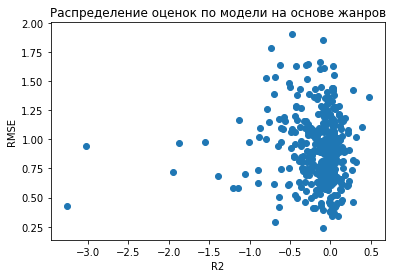

In [1094]:
plt.scatter(x=metrics_frame2['R2'], y=metrics_frame2['RMSE'])
plt.title('Распределение оценок по модели на основе жанров')
plt.xlabel('R2')
plt.ylabel('RMSE');

In [1095]:
metrics_frame = pd.DataFrame()

for i in a:
    user = i
    
    n = int(np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[:,6:]).shape[0]*0.8)

    X_train = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[:n,6:])
    y_train = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[:n,2])

    X_test = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[n+1:,6:])
    y_test = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[n+1:,2])

    model_knn_reg = KNeighborsRegressor(n_neighbors=20, n_jobs=-1)
    model_knn_reg.fit(X_train, y_train)
    result = model_knn_reg.predict(X_test)

    R2 = metrics.r2_score(y_test, result)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, result))

    row = [[user, R2, RMSE]]

    metrics_frame = metrics_frame.append(row)

In [1096]:
metrics_frame = metrics_frame.rename(columns={0: "user", 1: "R2", 2: "RMSE"})

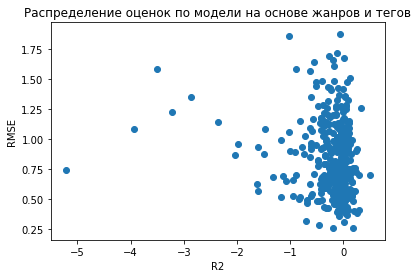

In [1097]:
plt.scatter(x=metrics_frame['R2'], y=metrics_frame['RMSE'])
plt.title('Распределение оценок по модели на основе жанров и тегов')
plt.xlabel('R2')
plt.ylabel('RMSE');

#### Рекомендации на основе расширенных данных, жанров и тегов, показали более точные по оценки как по RMSE, так и по R2

In [1098]:
metrics_frame[(metrics_frame['R2']>=0.2) & (metrics_frame['RMSE']<=1)]

,user,R2,RMSE
0,274,0.219882,0.569579
0,91,0.227826,0.903601
0,187,0.210782,0.759693
0,100,0.202281,0.567921
0,382,0.235162,0.728735
0,109,0.262375,0.387989
0,139,0.255818,0.920161
0,490,0.292202,0.700973
0,353,0.492500,0.705084
0,102,0.200250,0.403998


In [1128]:
user = 187
    
n = int(np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[:,6:]).shape[0]*0.8)

X_train = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[:n,6:])
y_train = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[:n,2])

X_test = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[n+1:,6:])
y_test = np.array(rating_movies_tags[rating_movies_tags['userId']==user].iloc[n+1:,2])

model_knn_reg = KNeighborsRegressor(n_neighbors=20, n_jobs=-1)
model_knn_reg.fit(X_train, y_train)
result = model_knn_reg.predict(X_test)

In [1129]:
user187 = rating_movies_tags[rating_movies_tags['userId']==user].iloc[n+1:,:6]
user187['predicts'] = result
user187

,userId,movieId,rating,timestamp,title,genres,predicts
27724,187,8228,4.0,1161954534,"Maltese Falcon, The (a.k.a. Dangerous Female) ...",Mystery,4.025
27726,187,8464,4.0,1161849808,Super Size Me (2004),Comedy Documentary Drama,4.050
27729,187,8607,4.0,1161849932,Tokyo Godfathers (2003),Adventure Animation Drama,3.775
27730,187,8622,3.0,1161849631,Fahrenheit 9/11 (2004),Documentary,3.825
27731,187,8636,1.0,1161863927,Spider-Man 2 (2004),Action Adventure SciFi IMAX,3.225
27732,187,8874,5.0,1161849541,Shaun of the Dead (2004),Comedy Horror,4.025
27733,187,8949,5.0,1161850300,Sideways (2004),Comedy Drama Romance,3.550
27734,187,8950,4.5,1161849388,The Machinist (2004),Drama Mystery Thriller,3.975
27735,187,8961,4.0,1161863972,"Incredibles, The (2004)",Action Adventure Animation Children Comedy,3.350
27737,187,25825,4.5,1180302171,Fury (1936),Drama FilmNoir,3.900


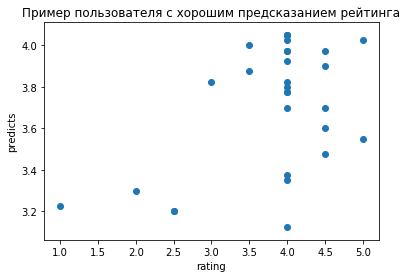

In [1130]:
plt.scatter(x=user187['rating'], y=user187['predicts'])
plt.title('Пример пользователя с хорошим предсказанием рейтинга')
plt.xlabel('rating')
plt.ylabel('predicts');